# ***Memory Agent***


## Goals

Now, we're going to pull together the pieces we've learned to build an [agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/) with long-term memory.

Our agent, `task_mAIstro`, will help us manage a ToDo list! 

The chatbots we built previously *always* reflected on the conversation and saved memories. 

`task_mAIstro` will decide *when* to save memories (items to our ToDo list).

The chatbots we built previously always saved one type of memory, a profile or a collection. 

`task_mAIstro` can decide to save to either a user profile or a collection of ToDo items.

In addition semantic memory, `task_mAIstro` also will manage procedural memory.

This allows the user to update their preferences for creating ToDo items. 

In [1]:
from IPython.display import display, Image
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
load_dotenv()
import os

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

groq_api_key = os.getenv("GROQ_API_KEY")

model = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

## Visibility into Trustcall updates

Trustcall creates and updates JSON schemas.

What if we want visibility into the *specific changes* made by Trustcall?

For example, we saw before that Trustcall has some of its own tools to:

* Self-correct from validation failures -- [see trace example here](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7) 
* Update existing documents -- [see trace example here](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

Visibility into these tools can be useful for the agent we're going to build.

Below, we'll show how to do this!

In [2]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    """This is the memory of user"""
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning LangGraph")
    
class MemoryCollection(BaseModel):
    """This is the list of memories about the user"""
    memories: list[Memory] = Field(description="A list of memories about the user.")

We can add a [listener](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners) to the Trustcall extractor.

This will pass runs from the extractor's execution to a class, `Spy`, that we will define.

Our `Spy` class will extract information about what tool calls were made by Trustcall.

In [3]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [4]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Alamin."), 
                AIMessage(content="Nice to meet you, Alamin."), 
                HumanMessage(content="This morning I had a nice bike ride in Bashundhara r/a, Dhaka.")]

## invoking
result = trustcall_extractor.invoke(
    {
        "messages": [SystemMessage(content=instruction)]+conversation
    }
)



In [5]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_xq39)
 Call ID: call_xq39
  Args:
    content: Alamin had a bike ride in Bashundhara r/a, Dhaka.


In [6]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Alamin had a bike ride in Bashundhara r/a, Dhaka.'


In [7]:
# Responses contain the memories that adhere to the schema
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_xq39'}


In [8]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Alamin had a bike ride in Bashundhara r/a, Dhaka.'})]

In [9]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation, 
                                                        "existing": existing_memories})

In [10]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_13z4'}


In [11]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_13z4)
 Call ID: call_13z4
  Args:
    content: Alamin had a bike ride in Bashundhara r/a, Dhaka. I went to Tartine and ate a croissant. I was thinking about my Japan, and going back this winter!


In [12]:
for m in result['responses']:
    print(m)

content='Alamin had a bike ride in Bashundhara r/a, Dhaka. I went to Tartine and ate a croissant. I was thinking about my Japan, and going back this winter!'


In [13]:
## Inspect the tool call made by TrustCall
spy.called_tools

[[{'name': 'Memory',
   'args': {'content': 'Alamin had a bike ride in Bashundhara r/a, Dhaka. I went to Tartine and ate a croissant. I was thinking about my Japan, and going back this winter!'},
   'id': 'call_13z4',
   'type': 'tool_call'}]]

In [14]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

New Memory created:
Content: {'content': 'Alamin had a bike ride in Bashundhara r/a, Dhaka. I went to Tartine and ate a croissant. I was thinking about my Japan, and going back this winter!'}


## Updated function

In [15]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """
    # Initialize list of changes
    changes = []
    
    # First, check if tool_calls is a list
    if not isinstance(tool_calls, list):
        return f"No {schema_name} updates to report."
    
    # Process each call, handling different potential structures
    for call_item in tool_calls:
        # Handle case where call_item is already a single call dict
        if isinstance(call_item, dict):
            # Process a single call dict
            if call_item.get('name') == 'PatchDoc' and isinstance(call_item.get('args'), dict):
                args = call_item.get('args', {})
                # Safely extract nested values
                doc_id = args.get('json_doc_id', 'unknown')
                planned_edits = args.get('planned_edits', '')
                # Safely handle patches which may be missing or not a list
                patches = args.get('patches', [])
                value = patches[0].get('value', '') if isinstance(patches, list) and len(patches) > 0 and isinstance(patches[0], dict) else ''
                
                changes.append({
                    'type': 'update',
                    'doc_id': doc_id,
                    'planned_edits': planned_edits,
                    'value': value
                })
            elif call_item.get('name') == schema_name and isinstance(call_item.get('args'), dict):
                changes.append({
                    'type': 'new',
                    'value': call_item.get('args', {})
                })
        # Handle case where call_item is a list of call dicts
        elif isinstance(call_item, list):
            for call in call_item:
                if not isinstance(call, dict):
                    continue
                    
                if call.get('name') == 'PatchDoc' and isinstance(call.get('args'), dict):
                    args = call.get('args', {})
                    # Safely extract nested values
                    doc_id = args.get('json_doc_id', 'unknown')
                    planned_edits = args.get('planned_edits', '')
                    # Safely handle patches which may be missing or not a list
                    patches = args.get('patches', [])
                    value = patches[0].get('value', '') if isinstance(patches, list) and len(patches) > 0 and isinstance(patches[0], dict) else ''
                    
                    changes.append({
                        'type': 'update',
                        'doc_id': doc_id,
                        'planned_edits': planned_edits,
                        'value': value
                    })
                elif call.get('name') == schema_name and isinstance(call.get('args'), dict):
                    changes.append({
                        'type': 'new',
                        'value': call.get('args', {})
                    })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    if not result_parts:
        return f"No {schema_name} updates to report."
    
    return "\n\n".join(result_parts)


schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

New Memory created:
Content: {'content': 'Alamin had a bike ride in Bashundhara r/a, Dhaka. I went to Tartine and ate a croissant. I was thinking about my Japan, and going back this winter!'}


## Creating an agent

There are many different [agent](https://langchain-ai.github.io/langgraph/concepts/high_level/) architectures to choose from.

Here, we'll implement something simple, a [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) agent.

This agent will be a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory: 

(a) Create or update a user `profile` with general user information 

(b) Add or update items in a ToDo list `collection`

(c) Update its own `instructions` on how to update items to the ToDo list

In [16]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

## My Graph

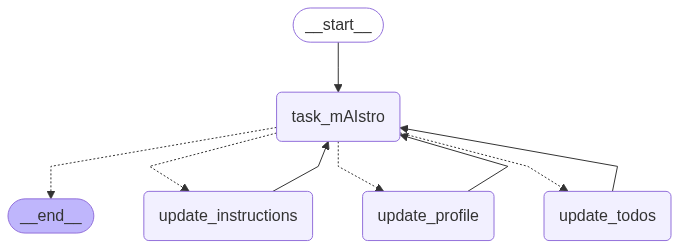

In [17]:
import uuid
from IPython.display import Image, display

from langchain_groq import ChatGroq
from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
import os
from dotenv import load_dotenv
load_dotenv()

groq_api_key = os.getenv("GORQ_API_KEY")

# Initialize the model
model = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    """This ToDo is use for update user to do task"""
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for choosing what to update and what tools to call 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

# def extract_tool_info(called_tools, tool_name):
#     """Extract information from tool calls for response message.
    
#     Args:
#         called_tools: List of tools called by Trustcall
#         tool_name: Name of the tool to extract info from
        
#     Returns:
#         A formatted message describing the updates made
#     """
#     # Initialize empty message
#     message = "ToDo list updated: "
    
#     # Check if there are any tool calls
#     if not called_tools:
#         return "No updates made to ToDo list."
    
#     # Process each tool call
#     updates = []
#     for call in called_tools:
#         # Make sure we're dealing with the right tool and call is a dictionary
#         if isinstance(call, dict) and call.get('name') == tool_name:
#             # Extract arguments safely
#             args = call.get('args', {})
#             if isinstance(args, dict):
#                 task = args.get('task', 'Unknown task')
#                 status = args.get('status', 'Unknown status')
#                 updates.append(f"{task} ({status})")
    
#     if updates:
#         message += ", ".join(updates)
#     else:
#         message = "ToDo list checked, but no specific updates made."
    
#     return message


def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls
    
    # Make sure tool_calls exists and has the expected structure
    if not tool_calls or not isinstance(tool_calls, list) or len(tool_calls) == 0:
        return {"messages": [{"role": "tool", "content": "Error: No tool calls found in the message.", "tool_call_id": "error"}]}
    
    # Make sure the first tool call has an 'id' key
    if not isinstance(tool_calls[0], dict) or 'id' not in tool_calls[0]:
        return {"messages": [{"role": "tool", "content": "Error: Invalid tool call format.", "tool_call_id": "error"}]}

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id": tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Testing

In [18]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "Alamin"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Al Amin. I live in Dhaka with my Friends. I have a bike and its Honda brand.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Al Amin. I live in Dhaka with my Friends. I have a bike and its Honda brand.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_ach6)
 Call ID: call_ach6
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

I'm glad I could update my knowledge about you, Al Amin. So, to confirm, your name is Al Amin, you live in Dhaka, your connections are Friends, and one of your interests is a bike, specifically a Honda brand bike. Is that correct?


In [19]:
# User input for a ToDo
input_messages = [HumanMessage(content="My friend asked me to book swim lessons for the his younger brother.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My friend asked me to book swim lessons for the his younger brother.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_hznc)
 Call ID: call_hznc
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'book swim lessons', 'solutions': ['SwimLife', 'Aquatic Center'], 'time_to_complete': 30, 'status': 'not started', 'deadline': '2025-05-21T00:00:00', 'user_name': 'Al Amin'}
================================== Ai Message ==================================

I've added a new task to your ToDo list: book swim lessons. I'll make sure to remind you about it. Let me know if there's anything else I can help you with!


In [20]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_sbbg)
 Call ID: call_sbbg
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

I've taken note of your updated instructions. I'll make sure to include specific local businesses/vendors when creating or updating ToDo items going forward. Is there anything else I can help you with?


In [21]:
# Check for updated instructions
user_id = "Alamin"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': 'Here are the updated instructions:\n\n**Updating ToDo List Items:**\n\nWhen creating or updating ToDo items, please include the following details:\n\n1. **Task description**: Clearly describe the task, e.g., "book swim lessons".\n2. **Specific local businesses/vendors**: Include specific local businesses or vendors that can help complete the task, e.g., "SwimLife" or "Aquatic Center".\n3. **Time to complete**: Estimate the time required to complete the task, e.g., 30 minutes.\n4. **Deadline**: Provide a deadline for completing the task, e.g., "2025-05-21T00:00:00".\n\nWhen adding new tasks, I will use these details to create a new ToDo item. Let me know if you have any further requests or updates!'}


In [22]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_dw47)
 Call ID: call_dw47
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'fix jammed electric Yale lock on the door', 'time_to_complete': 60, 'solutions': ['Locksmith Dhaka', 'Yale Customer Support'], 'deadline': None}
================================== Ai Message ==================================

I've added a new task to your ToDo list: fix the jammed electric Yale lock on the door. You might want to consider reaching out to Locksmith Dhaka or Yale Customer Support for help. Let me know if there's anything else I can assist you with!


In [23]:
# Namespace for the memory to save
user_id = "Alamin"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'book swim lessons', 'time_to_complete': 30, 'deadline': '2025-05-21T00:00:00', 'solutions': ['SwimLife', 'Aquatic Center'], 'status': 'not started'}
{'task': 'fix jammed electric Yale lock on the door', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Locksmith Dhaka', 'Yale Customer Support'], 'status': 'not started'}


In [24]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the swim lessons, I need to get that done by end of November.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_syq8)
 Call ID: call_syq8
  Args:
    update_type: todo
================================= Tool Message =================================

Document ec26d5ca-32cd-4b78-83aa-a826e47faf88 updated:
Plan: The deadline for the swim lessons task needs to be updated to the end of November.
Added content: 
================================== Ai Message ==================================

I've updated the deadline for the swim lessons task to the end of November. Your ToDo list is now up-to-date. Let me know if there's anything else I can help you with!


We can see that Trustcall performs patching of the existing memory:


In [25]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to call back City Toyota to schedule car service.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_2jk8)
 Call ID: call_2jk8
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'call back City Toyota to schedule car service', 'time_to_complete': 5, 'solutions': ['City Toyota'], 'status': 'not started', 'deadline': None}
================================== Ai Message ==================================

I've added a new task to your ToDo list: call back City Toyota to schedule car service. You might want to consider reaching out to City Toyota directly to get that scheduled. Let me know if there's anything else I can help you with!


In [26]:
# Namespace for the memory to save
user_id = "Alamin"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'book swim lessons', 'time_to_complete': 30, 'deadline': '2025-11-30T00:00:00', 'solutions': ['SwimLife', 'Aquatic Center'], 'status': 'not started'}
{'task': 'fix jammed electric Yale lock on the door', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Locksmith Dhaka', 'Yale Customer Support'], 'status': 'not started'}
{'task': 'call back City Toyota to schedule car service', 'time_to_complete': 5, 'deadline': None, 'solutions': ['City Toyota'], 'status': 'not started'}


Now we can create a new thread.

This creates a new session. 

Profile, ToDos, and Instructions saved to long-term memory are accessed. 

In [27]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "3", "user_id": "Alamin"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

To determine which tasks can be completed within 30 minutes, let's review the tasks in the ToDo list:


* book swim lessons: 30 minutes
* fix jammed electric Yale lock on the door: 60 minutes
* call back City Toyota to schedule car service: 5 minutes


Based on the time required for each task, the tasks that can be completed within 30 minutes are:


* book swim lessons
* call back City Toyota to schedule car service


You can complete either "book swim lessons" or "call back City Toyota to schedule car service" or both within 30 minutes. 

Would you like to proceed with any of these tasks?


In [28]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, give me some options to call for swim lessons.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_a5xc)
 Call ID: call_a5xc
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'book swim lessons', 'time_to_complete': 30, 'solutions': ['SwimLife', 'Aquatic Center']}
================================== Ai Message ==================================

Here are some options to call for swim lessons:

1. SwimLife
2. Aquatic Center

You can contact either of these centers to book your swim lessons.
